<a href="https://colab.research.google.com/github/IlyaZelinskiy/Wav2vec_CFT_SHIFT_LAB/blob/main/BERT_emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0


In [43]:
import pandas as pd
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import IPython
from IPython.display import Audio, display

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

Let's start by loading the dataset and taking a look at its structure.

In [2]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
timit['train']['text']

In [4]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

In [5]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained("bert-base-cased", output_hidden_states=True)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
text_token = []
for i in range(0, len(timit['train']['text'])):
    text_token.append(tokenizer.encode(timit['train']['text'][i], add_special_tokens=True))

In [7]:
len(text_token)

4620

In [8]:
len(text_token[1])

16

In [9]:
len(timit['train']['text'][1])

44

In [24]:
import torch
from tqdm import tqdm

In [25]:
def get_embeddings(num_layer):
    encoded = []
    for i in tqdm(range(0, len(text_token))):
        tokens_tensor = torch.tensor([text_token[i]])
        
        with torch.no_grad():
            embeddings = model(tokens_tensor)
            encoded.append(embeddings[2][num_layer])
    return encoded

In [26]:
embeddings_13 = get_embeddings(12)

100%|██████████| 4620/4620 [06:21<00:00, 12.10it/s]


In [41]:
embeddings_13[0][0].shape

torch.Size([11, 768])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.179695
[t-SNE] KL divergence after 1000 iterations: 0.522023


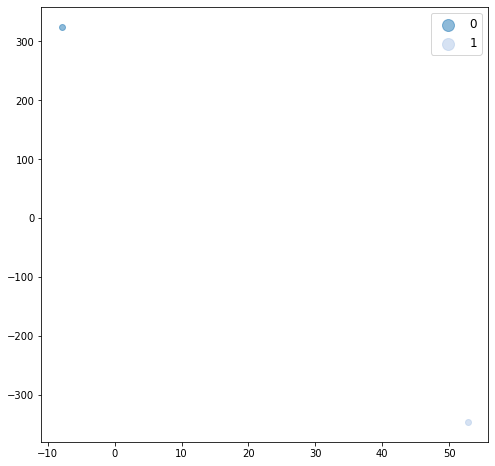

In [44]:
from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(embeddings_13[0][0])
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    # indices = test_predictions==lab
    indices = lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

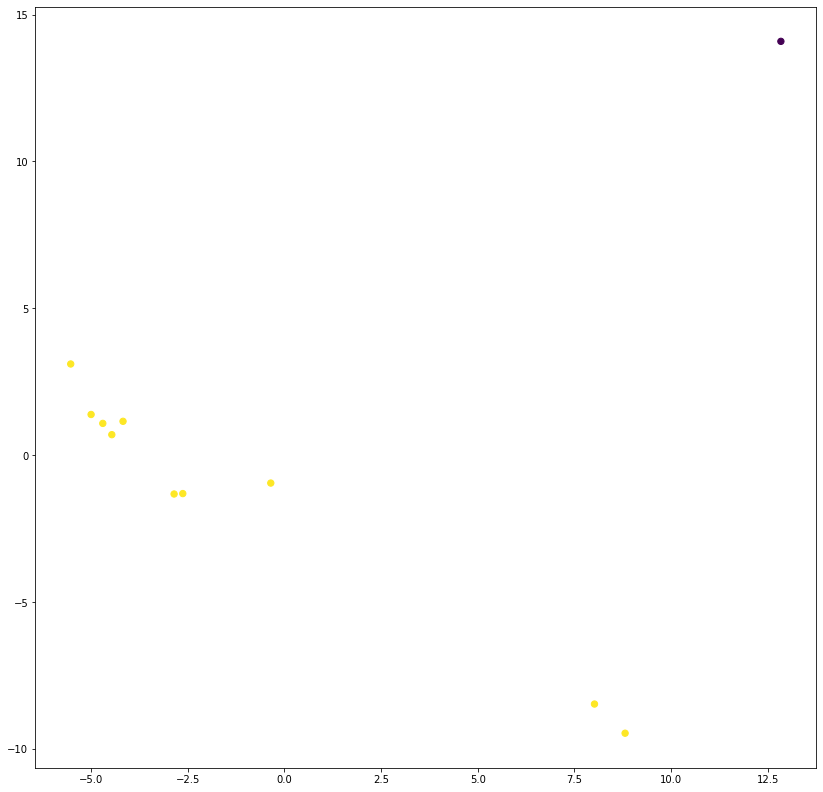

In [45]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

embeddings_2d = PCA(n_components=2, random_state=0).fit_transform(embeddings_13[0][0])
embeddings_2d
n_clusters = 2
gm = GaussianMixture(n_components=n_clusters).fit(embeddings_2d)
clusters = gm.predict(embeddings_2d)

plt.figure(figsize=(14, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=40, c=clusters)
plt.show()